# MD2SL Deep Learning Assignment: Convolutional Neural Networks

In this laboratory session we will train some CNNs to recognize color images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## IMPORTANT
+ Make sure to **interpret** your results and include detailed analysis using the rich markup features of Jupyter. Don't just submit code -- even if it works you **won't** receive full credit.
+ There is a plethora of information on building and training CNNs for image recognition (even for *exactly* this CIFAR-10 dataset). **Absolutely** make use of all available material, **but the solutions you submit must be your own**.

## Part 1: Initial Setup and Data Exploration

We begin with some standard imports, as usual.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [2]:
from torchvision.datasets import CIFAR10
#import torchvision.transforms as transforms
# We recommending using the torchvision.transforms.v2 transforms instead of those in torchvision.transforms
# (https://pytorch.org/vision/main/transforms.html)
from torchvision.transforms import v2 

# Validation set size.
val_size = 2000

# Your code here.
#"UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use..."
to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
# Carico i dati di addestramento
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=to_tensor)
# Carico i dati di test
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=to_tensor)

Files already downloaded and verified
Files already downloaded and verified


## Stratificazione del set di validazione
Poiché nel set di test il numero di esempi per ciascuna label è costante, si vuole replicare questa caratteristica anche nel set di validazione: a tal fine, invece di eseguire uno split puramente casuale sugli elementi di `cifar10_train`, si ricorre a `StratifiedShuffleSplit` che permette di stratificare gli esempi nel processo di split. 

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# Voglio creare il dataset di validazione, separandolo dal training set, stratificando per classi

# istanzio StratifiedShuffleSplit per selezionare casualmente 200 istanze per ciascuna delle 10 label
split = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=42)
train_index, valid_index = next(split.split(range(len(cifar10_train)), cifar10_train.targets))

## Standardizzazione
Vogliamo calcolare media e varianza dei 3 canali RGB sugli esempi del solo insieme di addestramento, escludendo quello di validazione: l'obbiettivo è rendere le immagini nell'insieme di addestramento complessivamente a media nulla e varianza unitaria nei tre canali  (la conversione in tensore scala automaticamente le immagini solo tra 0 e 1).
Tali valori (`train_avg` e `train_std`) verranno poi applicati alle istanze dei tre dataset tramite la funzione `Normalize()`; successivamente saranno richiesti anche nel metodo `denormalize()`, da usare ad esempio nel momento della visualizzazione a schermo delle immagini.

Per determinare media e varianza dei tre canali sull'intero insieme di addestramento, i valori RGB dei pixel di tutti gli esempi vengono aggregati lungo i tre canali del tensore batch (contenente tutte le immagini del dataset), per poi calcolare per ciascuno dei 3 assi rimasti media e deviazione standard dei campioni così ragguppati.

## Data augmentation
Inoltre per ogni esempio di quello che sarà l'insieme di addestramento si vuole creare randomicamente a runtime una sua versione leggermente alterata, ogni volta che un'immagine farà parte del batch corrente, applicando:
* un eventuale flip orizzontale,
* una piccola rotazione casuale non superiore a 5 gradi,
* ed un leggero zoom con fattore di scala casualmente scelto tra 0.9 e 1, lasciando le dimensioni dell'immagine invariate.
  
In alternativa si sarebbe potuto applicare una trasformazione affine del piano, ma tale operazione è sembrata più lenta da eseguire.

Tali deformazioni però non devono essere applicate all'insieme di validazione, il cui ruolo è quello di mimare in miniatura il test set (sul quale solo al termine verranno poi confrontati i vari modelli addestrati).

Quindi, volendo diversificare il set di addestramento da quello di validazione, viene definita anche una classe `Cifar10Subset` che avrà due istanze distinte a cui applicare o meno la catena di trasformazioni appena descritta. 

## Combinazione dei requisiti per la standardizzazione e data augmentation
Pertanto si procede come segue:
* il set di addestramento `train_set` e quello di validazione `valid_set` sono istanze distinte di `Cifar10Subset`
* la sequenza di trasformazioni passate in `transform` alle due istanze di `Cifar10Subset` vengono diversificate per i due insiemi:
    - per `train_set` la sequenza di trasformazioni `augmented_transform`, oltre alla conversione in tensore e quella di standardizzazione a media nulla e varianza unitaria, comprende un eventuale ribaltamento orizzontale `RandomHorizontalFlip`, una rotazione `RandomRotation` e uno zoom `RandomResizedCrop`
    - per `valid_test` la sequenza `basic_transform` converte l'immagine in tensore per poi standardizzarla secondo media e varianza trovati sul test set
    - in entambi i casi non è necessario applicare di nuovo la conversione delle immagini in tensori, dal momento che i dati della classe `Cifar10Subset` sono presi dalle istanze `cifar10_train` e `cifar10_test` (dove `to_tensor()` è già stata eseguita)
* per uniformità di implementazione, anche per l'insieme di test viene definita un'istanza `test_set` di `Cifar10Subset`, a cui viene passata la stessa sequenza di trasformazioni di `valid_test` (ossia `basic_transform`)

**Nota tecnica:** per poter essere usate come `Dataset`, occorre che `Cifar10Subset` implementi i metodi `__getitem__(self, index)` e `__len__ (self)`.


In [4]:
from torch.utils.data import Dataset, DataLoader

def compute_mean_std(ds):
    #carica tutto il set di immagini in ds in una sola volta
    dataloader = DataLoader(ds, batch_size=len(ds), shuffle=False) 

    for images, _ in dataloader:
        #l'indice 1 corrisponde ai 3 canali: ho la media sui 3 canali di tutti i pixel del dataset
        mean = torch.mean(images, dim=[0, 2, 3]) 
        #l'indice 1 corrisponde ai 3 canali: ho la dev. std. sui 3 canali di tutti i pixel del dataset
        std = torch.std(images, dim=[0, 2, 3])
        break

    return (mean.numpy().tolist(), std.numpy().tolist())

#------------------------------------------------------------------------------

class Cifar10Subset(Dataset):
    
    def __init__(self, cifar10, index_list, transform=None):
        super(Cifar10Subset, self).__init__()
        self.X = list()
        self.y = list()
        for idx in index_list:
            img, lab = cifar10[idx]
            self.X.append(img)
            self.y.append(lab)
        self.classes = cifar10.classes
        self.transform = transform

        
    def __getitem__(self, index):
        if (self.transform==None):
            return (self.X[index], self.y[index])
        else:
            Xmod = self.transform(self.X[index])
            return (Xmod, self.y[index])

    def __len__ (self):
        return len(self.X)

    @staticmethod
    def denormalize_image(img):
        mean = torch.tensor(train_avg).view(3, 1, 1)
        std = torch.tensor(train_std).view(3, 1, 1)
        img_den = img * std + mean
        return img_den


#------------------------------------------------------------------------------

# Creaione di train_set
train_set = Cifar10Subset(cifar10_train, train_index)
# Calcolo la media e la deviazione standard per ciascun canale (R, G, B)
train_avg, train_std = compute_mean_std(train_set)
print(train_avg)
print(train_std)

# passo a train_set una nuova sequenza di processing da impiegare nelle chiamate del DataLoader,
# per poi terminare con la trasformazione di standardizzazione
augmented_transform = v2.Compose([#v2.ToTensor(),
                                  # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
                                  # v2.ColorJitter(brightness=.2, hue=.1),
                                  # v2.RandomAffine(degrees=(5), 
                                  #                 translate=(0.05, 0.05), 
                                  #                 scale=(0.9, 1.0), 
                                  #                 shear=(5), 
                                  #                 interpolation=v2.InterpolationMode.BILINEAR, 
                                  #                 fill=train_avg), # Trasformazione affine
                                  v2.RandomHorizontalFlip(), # Ribaltamento orizzontale casuale
                                  v2.RandomRotation(5, fill=train_avg), # Rotazione casuale
                                  v2.RandomResizedCrop(size=(32,32), scale=(0.9,1.0)), # Zoom+Crop casuale
                                  v2.Normalize(train_avg, train_std) # standardizzazione
])

basic_transform = v2.Compose([v2.Normalize(train_avg, train_std)])

train_set.transform = augmented_transform

# Creazione di valid_set, passando come trasformazioni solo 
# conversione in tensore e standardizzazione secondo train_avg, train_std
valid_set = Cifar10Subset(cifar10_train, valid_index, transform = basic_transform)

# Creazione di test_set, passando come trasformazioni solo 
# conversione in tensore e standardizzazione secondo train_avg, train_std
test_set = Cifar10Subset(cifar10_test, range(len(cifar10_test)), transform = basic_transform)


[0.4912760853767395, 0.4821588099002838, 0.4465084969997406]
[0.24695418775081635, 0.24341784417629242, 0.26158633828163147]


### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [5]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256

# Creo i DataLoader

# NOTA:
# se num_workers>0 i dataloader mi funzionano solo in Colab, 
# altrimenti in Jupyter/Spider l'addestramento si blocca nella creazione dei batch 
# (non sono riuscito a determinare l'origine del problema nella mia installazione di Python).
# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=2, shuffle=False)
# test_loader  = DataLoader(test_set,  batch_size=batch_size, num_workers=2, shuffle=False)

# Pertanto, per garantire un'eventuale nuova esecuzione del notebook su altri pc, 
# si istanziano in via conservativa i DataLoader con num_workers pari al valore di default (0)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

## Controllo a campione dei dataset

OLtre alla definizione di una funzione per visualizzare alcuni esempi e le loro etichette associate (`show_random_examples()`), viene implementata anche la funzione `check_class_distrib()` che conta, per il dataset passatole in ingresso, il numero di esempi per ciascuna etichetta.

In [6]:
rseed = 6174
torch.manual_seed(rseed)

def check_class_distrib(subset):
    labels_list = subset.classes
    targets = subset.y
    #print(len(targets))
    counts = {} #costruisco un dizionario con coppie (chiave,valore) = (classe, # di elementi della classe)
    for id_lab in range(len(labels_list)):
        lab = labels_list[id_lab]
        counts[lab] = targets.count(id_lab)
    print(counts)

def show_random_examples(subset):
    labels_list = subset.classes
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 5, 5
    dataloader = DataLoader(subset, batch_size=cols*rows, shuffle=True)
    for batch in dataloader:
        inputs, targets = batch
        for i in range(0, cols * rows):
            img = inputs[i]
            idlab = targets[i]
            img_den = Cifar10Subset.denormalize_image(img)
            figure.add_subplot(rows, cols, i+1)
            plt.title(labels_list[idlab])
            plt.axis("off")
            plt.imshow(np.array(v2.ToPILImage()(img_den)), cmap='gray', vmin=0, vmax=255)
        break;
    plt.show()
    print(img.min(), img.max(), img.shape)

### train_set

Si verifica che ci sia lo stesso numero di esempi per classe (4800) e si visualizzano alcuni esempi con relativa label.

{'airplane': 4800, 'automobile': 4800, 'bird': 4800, 'cat': 4800, 'deer': 4800, 'dog': 4800, 'frog': 4800, 'horse': 4800, 'ship': 4800, 'truck': 4800}


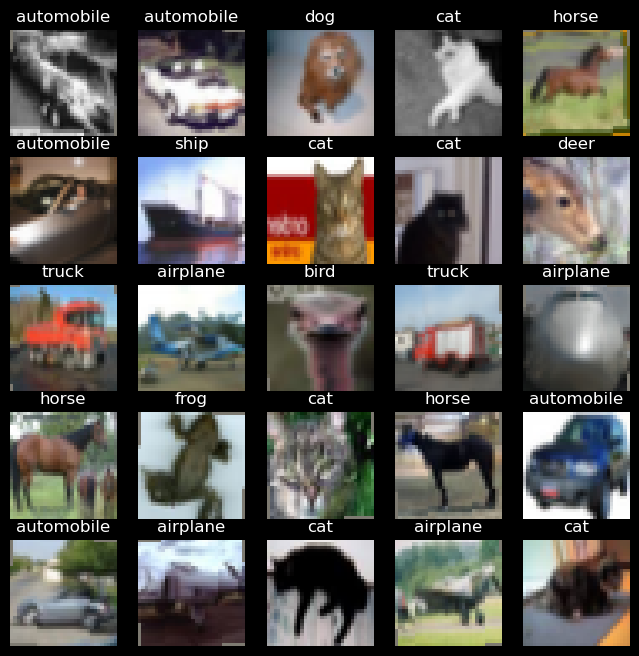

tensor(-1.9408) tensor(2.1077) torch.Size([3, 32, 32])


In [7]:
check_class_distrib(train_set)
show_random_examples(train_set)

#### valid_set
Si verifica che ci sia lo stesso numero di esempi per classe (200); inoltre vengono ispsezionate alcune immagini con check sulla label associata

{'airplane': 200, 'automobile': 200, 'bird': 200, 'cat': 200, 'deer': 200, 'dog': 200, 'frog': 200, 'horse': 200, 'ship': 200, 'truck': 200}


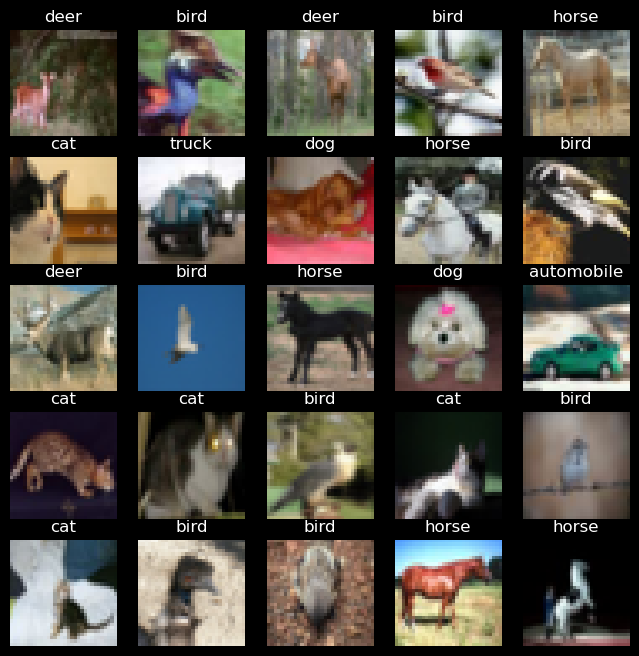

tensor(-1.9893) tensor(2.0110) torch.Size([3, 32, 32])


In [8]:
check_class_distrib(valid_set)
show_random_examples(valid_set)

#### test_set
Stessa procedura del valid_set, con 1000 esempi per classe

{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


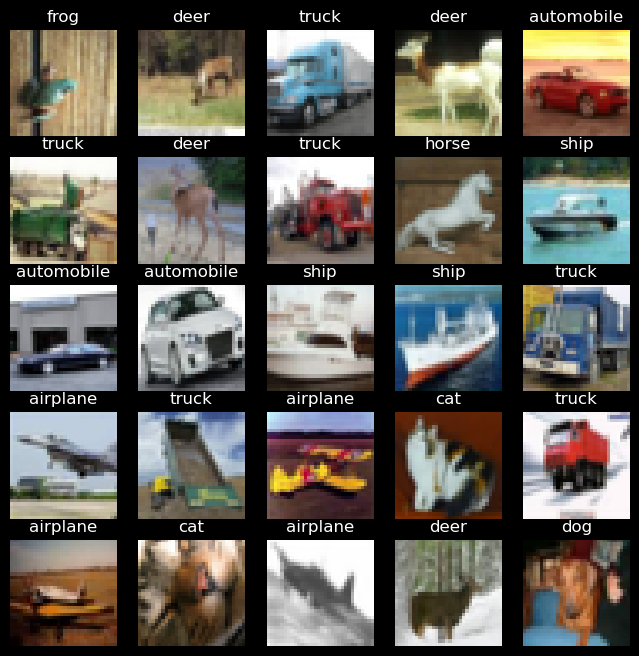

tensor(-1.9893) tensor(1.8059) torch.Size([3, 32, 32])


In [9]:
check_class_distrib(test_set)
show_random_examples(test_set)

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

## SimpleMLP
Definiamo una rete composta da 4 strati fully connected, a struttura piramidale: il primo strato deve avere 3072 ingressi per recepire tutti i 32x32 pixel per i 3 canali RGB (32x32x3=3072).

La classe prevede anche l'impiego di dropout (inserito tra uno strato e l'altro), attivabile attraverso il metodo `set_droput(dropout_perc)`, con `dropout_perc` in (0,1).

In [10]:
# Your code here.
class SimpleMLP(nn.Module):

    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(3072, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024,  512)
        self.fc4 = nn.Linear( 512,   10)
        self.dropout_perc = 0
        self.dropout = nn.Dropout(self.dropout_perc)


    def set_dropout(self, dropout_perc):
        self.dropout_perc = dropout_perc
        self.dropout = nn.Dropout(dropout_perc)
    
    def do_dropout(self, x):
        if self.dropout_perc > 0:
            return self.dropout(x)
        else: 
            return(x)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.do_dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.do_dropout(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.do_dropout(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x


### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

## La funzione TrainModel
Definiamo una funzione `trainModel` da chiamare per l'addestramento dei modelli nei vari esperimenti a seguire; essa itera sulle epoche caricando via via in batch gli esempi da `train_set` nella fase di backpropagation:
* al termine di ciascuna epoca, in fase di valutazione, viene determinato se il modello corrente sia quello che al momento minimizza la loss su `valid_set`;
* per completezza vengono calcolate anche la loss e l'accuratezza su `test_set` per ogni epoca;
* i valori misurati per la loss sono rispettivamente raccolti nelle liste `train_loss_history` `valid_loss_history` e `test_loss_history` sui tre dataset (e nelle liste `train_acc_history` `valid_acc_history` e `test_acc_history` vanno i valori relativi all'accuratezza), per essere visualizzati graficamente al termine dell'addestramento;
* in corso d'opera invece i valori misurati su ogni epoca vengono mostrati a schermo in forma tabellare, aggiungendo una riga di volta in volta;
* in uscita viene restituito il modello con la minima loss su `valid_set`.

In [11]:
# Your code here.
import torch.optim.lr_scheduler as lr_scheduler
import copy

def trainModel(epochs, model, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device):

    torch.manual_seed(rseed)
    
    #size = len(train_loader.dataset)
    train_loss_history = list()
    valid_loss_history = list()
    test_loss_history = list()
    
    train_acc_history = list()
    valid_acc_history = list()
    test_acc_history = list()
    
    best_model = None
    best_loss = np.inf
    best_loss_epoch = 0
    
    print('Epoch\t learn. rate\t Train Acc.\t Train Loss\t Val. Acc.\t Val. Loss\t | Test Acc.\t Test Loss')
    print('--------------------------------------------------------------------------------------------------------------------')
    for epoch in range(epochs):
        
        lr = optimizer.param_groups[0]['lr']
            
        #training
        model.train() # imposto la modalità di train
        
        train_loss, train_correct = 0, 0
        for batch, (X, y) in enumerate(train_loader):
            # Compute prediction and loss
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            
            train_loss += loss
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        scheduler.step() # per poter variare il learning rate
          
        #testing  
        valid_size = len(valid_loader.dataset)
        valid_batches = len(valid_loader)
        valid_loss, valid_correct = 0, 0
        test_size = len(test_loader.dataset)
        test_batches = len(test_loader)
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            
            model.eval() # passo dalla modalità train a quella eval
            
            for X, y in valid_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                valid_loss += loss_fn(pred, y).item()
                valid_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
        train_loss /= len(train_loader)
        train_correct /= len(train_loader.dataset)/100
        tensor_cpu = train_loss.cpu();
        train_loss_history.append(tensor_cpu.detach())
        train_acc_history.append(train_correct)
    
        valid_loss /= valid_batches
        valid_loss_history.append(valid_loss)
        valid_correct /= valid_size/100
        valid_acc_history.append(valid_correct)
        
        test_loss /= test_batches
        test_loss_history.append(test_loss)
        test_correct /= test_size/100
        test_acc_history.append(test_correct)
        print(f"{epoch+1} \t {lr:>0.5f}\t {train_correct:>0.1f}%\t\t {train_loss:>0.3f}\t\t {valid_correct:>0.1f}%\t\t {valid_loss:>0.3f}\t\t | {test_correct:>0.1f}%\t {test_loss:>0.3f}")
        
        if (best_loss > valid_loss):
            best_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_loss_epoch = epoch

    # output a schermo per il miglior modello
    bestMdl_TestAcc = test_acc_history[best_loss_epoch]
    bestMdl_ValidAcc = valid_acc_history[best_loss_epoch]
    print(f"Best model at epoch {best_loss_epoch+1}: Test Acc. {bestMdl_TestAcc:>0.1f}% (Valid Acc. {bestMdl_ValidAcc:>0.1f}%)")
    
    # plotting training history
    fig = plt.figure(figsize=(8, 6))
    #
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('Loss')
    plt.plot(range(1,epochs+1), train_loss_history, label='train', color='tab:blue')
    plt.plot(range(1,epochs+1), valid_loss_history, label='valid', color='tab:orange')
    plt.plot(range(1,epochs+1), test_loss_history,  label='test',  color='tab:green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(True, which='both', linestyle=':', color='gray')
    plt.ylim(-0.01, 2.501); plt.yticks(np.arange(0, 2.51, 0.25))
    plt.xlim(0,epochs+1); plt.xticks(np.arange(0,epochs+1,5)); 
    plt.legend()
    #
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('Accuracy %')
    plt.plot(range(1,epochs+1), train_acc_history, label='train', color='tab:blue')
    plt.plot(range(1,epochs+1), valid_acc_history, label='valid', color='tab:orange')
    plt.plot(range(1,epochs+1), test_acc_history,  label='test',  color='tab:green')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(True, which='both', linestyle=':', color='gray')
    plt.ylim(-0.5, 100.5); plt.yticks(np.arange(0, 100.1, 10))
    plt.xlim(0,epochs+1); plt.xticks(np.arange(0,epochs+1,5));
    plt.legend()
    plt.show()

    return best_model


## Un po' di validazione
Impostiamo inizialmente cinque possibili valori di learning rate a tasso costante, da $10^{-5}$ a $10^{-1}$, al fine di verificare quale possa funzionare meglio per la rete MLP in termini di capacità di generalizzazione:
* viene individuato come modello migliore quello che minimizza la loss sul set di validazione su tutto il processo di addestramento, facendo girare `trainModel()` su 20 epoche per ogni learning rate;
* l'accuratezza sul set di validazione di tale modello costituisce l'indice da confrontare per i vari learning rate.

Valutiamo inoltre tali learning rate su due algoritmi di ottimizzazione: Stochastic Gradient Descent e Adam; per non introdurre troppi iper-parametri da validare, sarà preso in considerazione solo il learning rate lasciando gli altri parametri al loro valore di default.

Verrà poi impiegata la stessa configurazione (stesso learning rate e stesso ottimizzatore) anche per la rete convoluzionale (CNN): così facendo viene dato un po' di vantaggio alla rete MLP, in quanto non è detto che la stessa configurazione sia ottima anche per la rete CNN.

La funzione `trainModel()` richiede in ingresso anche uno scheduler per variare il learning rate: in questa fase lo scheduler è reso inattivo impostando `gamma=1` (al primo passo, senza perdere di generalità) nella definizione di `scheduler`.

La loss impiegata è fornita in tutti gli esperimenti dalla funzione `CrossEntropyLoss`, in quanto perfettamente adatta al tipo di problema (classificazione).

### Il silent check
Prima di applicare a tappeto `trainModel()` per le varie coppie di ottimizzatori e learinig rate conviene eseguire un controllo, che assicuri l'affidabilità del codice finora implementato, basato sulla seguente euristica: forzando l'addestramento sempre sul solito batch, l'accuratezza su di esso deve arrivare al 100%; la funzione `silent_check()` implementa tale verifica.

In [12]:
# impostazione del device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Found device: " + str(device))

def silent_check(model, batch_check, epochs, learning_rate, optSGD=True):
    loss_fn = torch.nn.CrossEntropyLoss()
    # per semplicità mi limito a considerare solo gli ottimizzatori impiegati in questo notebook
    if optSGD==True:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    X,y = batch_check
    #for X,y in data_loader:
    #    data, labels = X,y
    #    break

    for epoch in range(epochs):
        #training
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss, current = loss.item(), batch * len(X)
        loss = loss.item()
        acc=(pred.argmax(1) == y).type(torch.float).mean()
        #print(f"accuracy: {100*acc:.2f}% (loss: {loss:>7f})")
        if acc==1:
            final_epoch = epoch
            break
    if acc==1:
        print(f"accuracy: {100*acc:.2f}% (loss: {loss:>7f}) in {epoch+1} epochs: silent check ok")
    else:
        print(f"accuracy: {100*acc:.2f}% (loss: {loss:>7f}) in {epoch+1} epochs: silent check not passed")

Found device: cuda


### Adam
Attraverso la funzione `silent_check()`, definita nella precedente cella, facciamo una verifica iniziale per il modello sui vari learning rate.

In [13]:
# silent check per SimpleMLP con ADAM
for X_sc,y_sc in valid_loader: #senza perdere di generalità usiamo valid_loader perché non soggetto ad aletorietà nella creazione dei batch
    data_dummy, lab_dummy = X_sc,y_sc
    break

for lr in (1e-5, 1e-4, 1e-3, 1e-2, 1e-1):
    print(lr)
    rseed = 6174
    torch.manual_seed(rseed)
    modelMLP = SimpleMLP()
    silent_check(model=modelMLP, batch_check=(X_sc,y_sc), epochs=200, learning_rate=lr, optSGD=False)

1e-05
accuracy: 99.61% (loss: 0.284783) in 200 epochs: silent check not passed
0.0001
accuracy: 100.00% (loss: 0.092877) in 35 epochs: silent check ok
0.001
accuracy: 100.00% (loss: 0.031079) in 17 epochs: silent check ok
0.01
accuracy: 95.70% (loss: 0.123911) in 200 epochs: silent check not passed
0.1
accuracy: 14.84% (loss: 2.217774) in 200 epochs: silent check not passed


**Osservazione:** nell'ultimo caso notiamo che la convergenza è estremamente difficile (la loss non si è ancora discostata molto da -ln(1/10)=2.30... che si ottiene tirando completamente a caso su 10 classi), per cui evitiamo di validare Adam con learning rate a 0.1; anche la validazione per i learning rate a $10^{-5}$ e $10^{-2}$ sono probabilmente inutili, ma le lasciamo per avere un riscontro visivo rispetto ai restanti learning rate ($10^{-4}$ e $10^{-3}$), molto più veloci nel raggiungere il 100% di accuracy sul batch di check.

#### Esperimento 2.A1 (Adam, lr=1e-5)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00001	 29.5%		 2.046		 35.5%		 1.842		 | 36.4%	 1.823
2 	 0.00001	 38.4%		 1.756		 41.4%		 1.690		 | 41.9%	 1.667
3 	 0.00001	 41.9%		 1.654		 44.0%		 1.623		 | 44.8%	 1.596
4 	 0.00001	 44.1%		 1.598		 45.6%		 1.574		 | 46.3%	 1.549
5 	 0.00001	 45.5%		 1.555		 46.2%		 1.544		 | 47.5%	 1.513
6 	 0.00001	 46.7%		 1.523		 47.2%		 1.519		 | 47.7%	 1.485
7 	 0.00001	 47.9%		 1.492		 47.8%		 1.496		 | 48.8%	 1.462
8 	 0.00001	 48.7%		 1.467		 47.0%		 1.475		 | 49.8%	 1.439
9 	 0.00001	 49.5%		 1.446		 49.0%		 1.458		 | 50.4%	 1.423
10 	 0.00001	 50.1%		 1.425		 49.1%		 1.446		 | 51.2%	 1.406
11 	 0.00001	 50.9%		 1.405		 49.6%		 1.426		 | 51.5%	 1.390
12 	 0.00001	 51.3%		 1.391		 50.0%		 1.416		 | 51.9%	 1.378
13 	 0.00001	 51.8%		 1.376		 50.6%		 1.402		 | 52.3%	 1.365
14 	 0.000

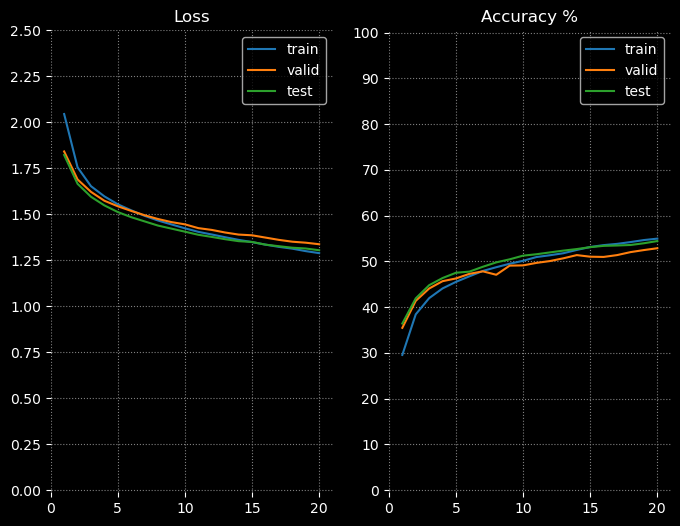

In [14]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-5
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_adam_1e_5 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Per learning rate pari a $10^{-5}$ le curve per loss e accuracy sui tre dataset sono "smooth" e molto simili: tuttavia in questo caso la convergenza è un po' lenta e ci sarebbe margine di miglioramento andando oltre le 30 epoche.

### Esperimento 2.A2  (Adam, lr=1e-4)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 39.5%		 1.712		 44.6%		 1.551		 | 46.7%	 1.516
2 	 0.00010	 47.4%		 1.491		 47.9%		 1.469		 | 49.7%	 1.432
3 	 0.00010	 50.4%		 1.405		 49.1%		 1.405		 | 51.2%	 1.379
4 	 0.00010	 52.6%		 1.343		 52.0%		 1.340		 | 54.0%	 1.317
5 	 0.00010	 54.8%		 1.289		 52.1%		 1.330		 | 54.4%	 1.301
6 	 0.00010	 56.4%		 1.245		 53.6%		 1.283		 | 55.6%	 1.264
7 	 0.00010	 57.8%		 1.203		 54.7%		 1.262		 | 56.2%	 1.256
8 	 0.00010	 59.1%		 1.172		 55.8%		 1.258		 | 56.8%	 1.238
9 	 0.00010	 60.0%		 1.142		 56.7%		 1.239		 | 56.9%	 1.233
10 	 0.00010	 61.1%		 1.106		 56.5%		 1.249		 | 57.0%	 1.223
11 	 0.00010	 62.1%		 1.077		 56.9%		 1.215		 | 58.0%	 1.198
12 	 0.00010	 63.1%		 1.051		 56.2%		 1.227		 | 58.2%	 1.203
13 	 0.00010	 64.1%		 1.021		 59.2%		 1.191		 | 59.2%	 1.174
14 	 0.000

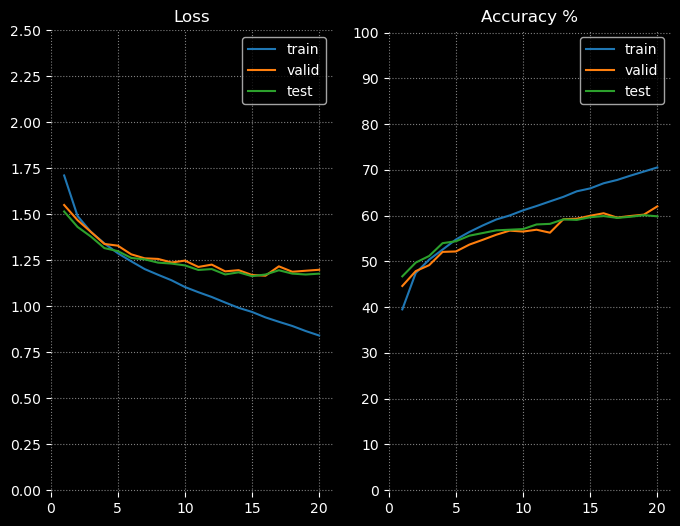

In [15]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-4
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_adam_1e_4 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Per leaning rate di $10^{-4}$ si nota che la rete inizia a perdere la capacità di generalizzare superando le 16 epoche: la loss su `train_set` continua a decrescere ma le loss per `valid_set` e `test_set` si stabilizzano intorno a 1.2, mostrando semmai un lieve accenno di risalita.

### Esperimento 2.A3  (Adam, lr=1e-3)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00100	 39.5%		 1.695		 44.9%		 1.544		 | 47.0%	 1.515
2 	 0.00100	 46.9%		 1.498		 48.1%		 1.451		 | 49.7%	 1.424
3 	 0.00100	 49.6%		 1.414		 47.5%		 1.458		 | 49.1%	 1.413
4 	 0.00100	 52.0%		 1.349		 50.3%		 1.383		 | 52.0%	 1.354
5 	 0.00100	 54.3%		 1.290		 51.0%		 1.396		 | 52.2%	 1.356
6 	 0.00100	 55.5%		 1.249		 53.4%		 1.310		 | 54.9%	 1.291
7 	 0.00100	 56.9%		 1.212		 53.2%		 1.323		 | 55.0%	 1.293
8 	 0.00100	 58.0%		 1.178		 53.1%		 1.352		 | 54.1%	 1.313
9 	 0.00100	 59.1%		 1.147		 55.2%		 1.297		 | 55.2%	 1.299
10 	 0.00100	 60.0%		 1.118		 53.8%		 1.328		 | 55.0%	 1.306
11 	 0.00100	 61.4%		 1.078		 55.4%		 1.315		 | 55.3%	 1.295
12 	 0.00100	 62.1%		 1.058		 55.1%		 1.341		 | 55.2%	 1.311
13 	 0.00100	 62.8%		 1.030		 56.0%		 1.318		 | 56.9%	 1.298
14 	 0.001

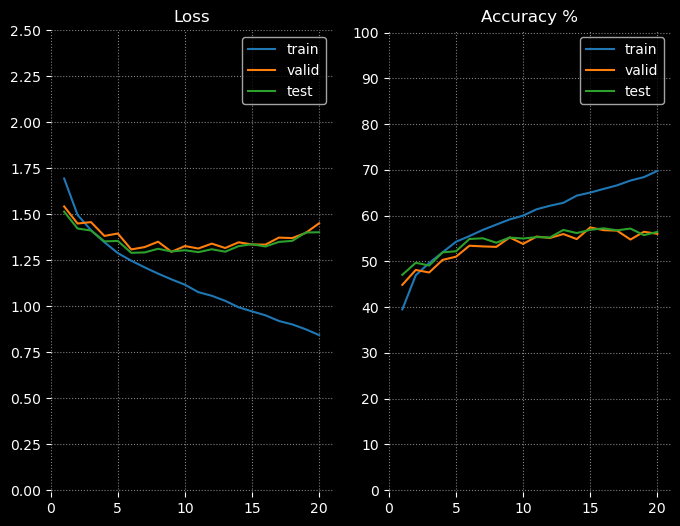

In [16]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-3
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_adam_1e_3 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Per learning rate $10^{-3}$ la capacità di generalizzare iniza a venir meno dopo 9 epoche, assistendo ad un chiaro innalzamento delle loss su `vali_set` e `test_set` mentre quella su `train_set` continua a calare molto velocemente: ci troviamo in una chiara situazione di overfitting.

### Esperimento 2.A4  (Adam, lr=1e-2)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.01000	 10.4%		 5.287		 10.0%		 2.303		 | 10.0%	 2.304
2 	 0.01000	 10.1%		 2.306		 10.0%		 2.303		 | 10.0%	 2.303
3 	 0.01000	 10.1%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
4 	 0.01000	 10.1%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
5 	 0.01000	 10.0%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
6 	 0.01000	 9.7%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
7 	 0.01000	 9.9%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
8 	 0.01000	 9.9%		 2.304		 10.0%		 2.303		 | 10.0%	 2.303
9 	 0.01000	 10.0%		 2.304		 10.0%		 2.303		 | 10.0%	 2.303
10 	 0.01000	 9.7%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
11 	 0.01000	 10.0%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
12 	 0.01000	 9.8%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
13 	 0.01000	 9.9%		 2.303		 10.0%		 2.303		 | 10.0%	 2.303
14 	 0.01000	 10

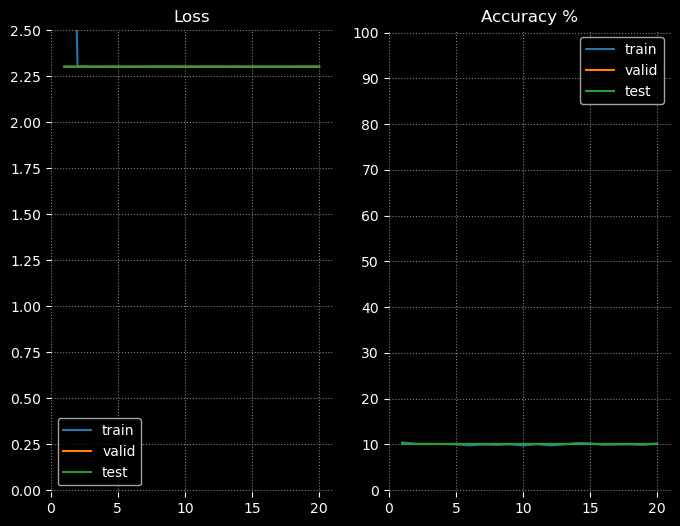

In [17]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-2
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_adam_1e_2 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Nell'ultimo caso vediamo che la rete nelle prime 30 epoche resta praticamente ferma alla predizione casuale delle 10 classi, con accuracy del 10% su tutti e tre i dataset monitorati.

### SGD
Eseguiamo anche in questo caso un silent check per la rete MLP impiegando l'ottimizzatore SGD al variare dei 5 learning rate d'interesse.

In [18]:
# silent check per SimpleMLP con SGD
# riuso il batch (X_sc,y_sc) di Adam...
for lr in (1e-5, 1e-4, 1e-3, 1e-2, 1e-1):
    print(lr)
    rseed = 6174
    torch.manual_seed(rseed)
    modelMLP = SimpleMLP()
    silent_check(model=modelMLP, batch_check=(X_sc,y_sc), epochs=200, learning_rate=lr, optSGD=True)

1e-05
accuracy: 9.77% (loss: 2.303500) in 200 epochs: silent check not passed
0.0001
accuracy: 10.94% (loss: 2.300995) in 200 epochs: silent check not passed
0.001
accuracy: 26.56% (loss: 2.277336) in 200 epochs: silent check not passed
0.01
accuracy: 39.84% (loss: 1.973758) in 200 epochs: silent check not passed
0.1
accuracy: 100.00% (loss: 0.142300) in 83 epochs: silent check ok


**Osservazione:** anche in questo caso sembra inutile validare i primi tre learning rate; lasciamo il valore di 0.01 per avere un confronto con l'unico learning rate che pare efficace (cioè 0.1).

### Esperimento 2.B1 (SGD, lr=1e-2)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.01000	 22.8%		 2.239		 25.2%		 2.157		 | 26.0%	 2.148
2 	 0.01000	 27.8%		 2.063		 29.1%		 1.989		 | 30.5%	 1.968
3 	 0.01000	 32.0%		 1.924		 33.1%		 1.884		 | 34.5%	 1.858
4 	 0.01000	 35.2%		 1.835		 36.6%		 1.800		 | 37.5%	 1.778
5 	 0.01000	 37.6%		 1.766		 40.0%		 1.737		 | 40.1%	 1.715
6 	 0.01000	 39.5%		 1.713		 40.5%		 1.687		 | 41.5%	 1.664
7 	 0.01000	 41.0%		 1.668		 41.5%		 1.648		 | 43.1%	 1.623
8 	 0.01000	 42.4%		 1.632		 42.5%		 1.620		 | 44.3%	 1.591
9 	 0.01000	 43.6%		 1.603		 43.8%		 1.592		 | 45.2%	 1.565
10 	 0.01000	 44.4%		 1.574		 44.8%		 1.567		 | 46.3%	 1.536
11 	 0.01000	 45.4%		 1.547		 45.9%		 1.537		 | 46.9%	 1.512
12 	 0.01000	 46.4%		 1.523		 46.5%		 1.516		 | 47.8%	 1.488
13 	 0.01000	 47.1%		 1.500		 47.6%		 1.497		 | 48.2%	 1.469
14 	 0.010

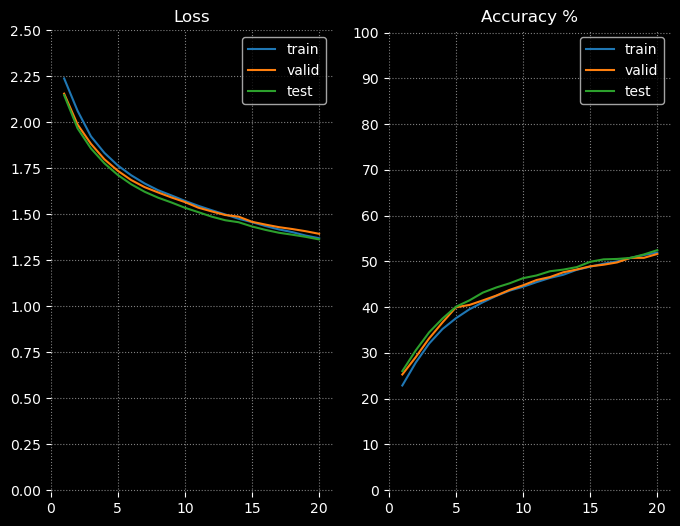

In [19]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-2
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_sgd_1e_2 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

In maniera simile all'esperimento 2.A1, anche qui il learning rate è un po' basso e la rete converge lentamente.

### Esperimento 2.B2 (SGD, lr=1e-1)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.10000	 34.1%		 1.853		 41.9%		 1.651		 | 42.2%	 1.628
2 	 0.10000	 43.8%		 1.587		 46.1%		 1.523		 | 47.0%	 1.499
3 	 0.10000	 47.7%		 1.482		 46.2%		 1.473		 | 48.3%	 1.437
4 	 0.10000	 50.2%		 1.420		 46.6%		 1.478		 | 48.2%	 1.455
5 	 0.10000	 51.8%		 1.370		 48.4%		 1.466		 | 49.9%	 1.420
6 	 0.10000	 53.3%		 1.323		 50.8%		 1.383		 | 51.7%	 1.375
7 	 0.10000	 54.9%		 1.285		 52.4%		 1.352		 | 53.6%	 1.324
8 	 0.10000	 56.4%		 1.242		 51.4%		 1.370		 | 52.7%	 1.335
9 	 0.10000	 57.0%		 1.219		 55.6%		 1.280		 | 55.1%	 1.263
10 	 0.10000	 58.2%		 1.185		 54.2%		 1.307		 | 54.3%	 1.283
11 	 0.10000	 58.8%		 1.162		 53.9%		 1.290		 | 54.3%	 1.280
12 	 0.10000	 60.0%		 1.134		 56.6%		 1.238		 | 56.8%	 1.223
13 	 0.10000	 61.0%		 1.106		 52.5%		 1.369		 | 54.6%	 1.326
14 	 0.100

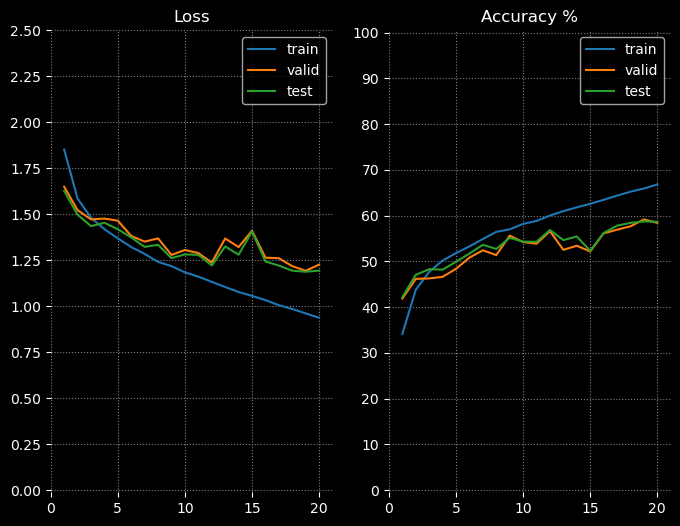

In [20]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-1
epochs = 20

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_sgd_1e_1 = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

L'algoritmo SGD con learning rate 0.1 consente di giuungere a prestazioni paragonabili all'esperimento 2.A2, anche se le loss su `valid_set` e `test_set` sono piuttosto nervose a differenza di quelle ottenute con Adam. 

### Riepilogo
Ricapitoliamo quindi i risultati ottenuti per i vari learning rate sui due algoritmi di ottimizzazione, avendo selezionato all'interno delle 20 epoche di addestramento come modello migliore _quello che minimizza la loss sul validation set_. 

| learning rate | Adam Valid. Acc.   | Adam Test Acc.     | SGD Valid. Acc.| SGD Test Acc.  |
|---------------|--------------------|--------------------|----------------|----------------|
|         1e-5  |   52.9%   _(2.A1)_ |   54.4%   _(2.A1)_ |             -- |             -- |
|         1e-4  | **60.5%** _(2.A2)_ | **59.9%** _(2.A2)_ |             -- |             -- |
|         1e-3  |   55.2%   _(2.A3)_ |   55.2%   _(2.A3)_ |             -- |             -- |
|         1e-2  |   10.0%   _(2.A4)_ |   10.0%   _(2.A4)_ | 51.6% _(2.B1)_ | 52.4% _(2.B1)_ |
|         1e-1  |                 -- |                 -- | 59.1% _(2.B2)_ | 58.7% _(2.B2)_ |

Dai dati ricavati le migliori combinazioni sono fornite dall'ottimizzatore Adam con learning rate pari a 1e-4 (esperimento 1.A2), e da SGD con learning rate di 0.1 (1.B2): anche se i risultati forniti sono paragonabli, decidiamo di proseguire con Adam applicando un learning rate costante pari a $10^-4$ sia perché ha funzionato leggermente meglio sia perché più suscettibile di miglioramenti mentre SGD con learning rate 0.1 sembrava già abbastanza al limite. 

Per la configurazione così selezionata decidiamo di prolungare l'addestramento a 30 epoche, nell'esperimento che segue, per appurare se le loss su `valid_test` e `test_set` restino stabili o meno intorno al valore di 1.2.

**NB:** la buona corrispondenza tra `valid_set` e `test_set`, sia in termini di loss che di accuratezza, in tutti gli esperimenti condotti è indice che lo split stratificato per classi impiegato nella creazione di `valid_set` ha funzionato bene.

### Esperimento 2.C

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 39.5%		 1.712		 44.6%		 1.551		 | 46.7%	 1.516
2 	 0.00010	 47.4%		 1.491		 47.9%		 1.469		 | 49.7%	 1.432
3 	 0.00010	 50.4%		 1.405		 49.1%		 1.405		 | 51.2%	 1.379
4 	 0.00010	 52.6%		 1.343		 52.0%		 1.340		 | 54.0%	 1.317
5 	 0.00010	 54.8%		 1.289		 52.1%		 1.330		 | 54.4%	 1.301
6 	 0.00010	 56.4%		 1.245		 53.6%		 1.283		 | 55.6%	 1.264
7 	 0.00010	 57.8%		 1.203		 54.7%		 1.262		 | 56.2%	 1.256
8 	 0.00010	 59.1%		 1.172		 55.8%		 1.258		 | 56.8%	 1.238
9 	 0.00010	 60.0%		 1.142		 56.7%		 1.239		 | 56.9%	 1.233
10 	 0.00010	 61.1%		 1.106		 56.5%		 1.249		 | 57.0%	 1.223
11 	 0.00010	 62.1%		 1.077		 56.9%		 1.215		 | 58.0%	 1.198
12 	 0.00010	 63.1%		 1.051		 56.2%		 1.227		 | 58.2%	 1.203
13 	 0.00010	 64.1%		 1.021		 59.2%		 1.191		 | 59.2%	 1.174
14 	 0.000

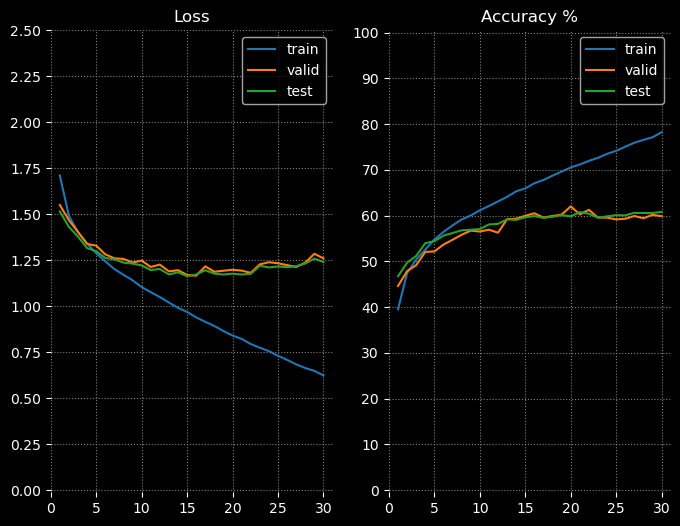

In [21]:
rseed = 6174
torch.manual_seed(rseed)

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_aug = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Nell'ultimo esperimento il numero di epoche è stato portato a 30 rispetto a 2.A2 per vedere se, andando avanti un altro po' nell'addestramento, si potesse migliorare ulteriormente: quello che si osserva è invece la conferma di overfitting, con le loss di `valid_set` e `test_set` che adesso risalgono in modo palese mentre la loss sull'insieme di training continua a calare in maniera costante.

Pertanto il miglior risultato per la MLP è stato confermato quello dell'esperimento 2.A2, con **accuracy su test set pari a 59.9%.**

### L'importanza della data augmentation
Finora tutti gli esperimenti condotti hanno visto l'impiego della data augmentation nella loro esecuzione: cosa sarebbe successo senza, standardizzando semplicemente i dati?

#### Esperimento 2.D (no data augmentation)
Si ripete lo stesso addestramento dell'esperimento 2.C usando però la `basic_transform` come sequenza di preprocessing nella creazione dei batch: il risultato mostra come la rete vada velocemente in overfitting, con la training loss che continua a calare mentre entrambe le loss sul validation set e test set, dopo un iniziale calo, aumentano molto ripidamente.

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 40.3%		 1.696		 45.6%		 1.538		 | 47.3%	 1.506
2 	 0.00010	 49.6%		 1.437		 48.1%		 1.447		 | 50.0%	 1.420
3 	 0.00010	 54.0%		 1.313		 51.5%		 1.387		 | 52.4%	 1.347
4 	 0.00010	 57.9%		 1.211		 52.3%		 1.353		 | 53.9%	 1.326
5 	 0.00010	 61.0%		 1.124		 53.0%		 1.325		 | 54.1%	 1.314
6 	 0.00010	 64.2%		 1.033		 54.2%		 1.349		 | 54.2%	 1.340
7 	 0.00010	 67.0%		 0.954		 55.5%		 1.345		 | 54.6%	 1.350
8 	 0.00010	 70.0%		 0.867		 54.1%		 1.357		 | 55.4%	 1.344
9 	 0.00010	 73.2%		 0.780		 54.2%		 1.357		 | 55.9%	 1.337
10 	 0.00010	 76.4%		 0.696		 54.1%		 1.392		 | 54.6%	 1.405
11 	 0.00010	 78.4%		 0.632		 52.9%		 1.486		 | 54.5%	 1.491
12 	 0.00010	 81.5%		 0.549		 55.2%		 1.513		 | 55.0%	 1.500
13 	 0.00010	 84.3%		 0.469		 54.1%		 1.566		 | 55.8%	 1.556
14 	 0.000

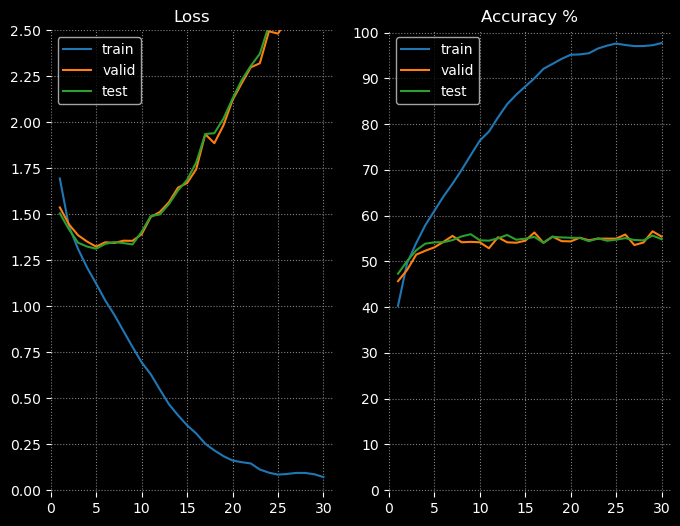

In [22]:
rseed = 6174
torch.manual_seed(rseed)

train_set.transform = basic_transform

modelMLP = SimpleMLP()
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_basic = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

### Con dropout

Anche il dropout non è stato ancora chiamato in gioco; pertanto si eseguono due esperimenti:
* 2.E1, con dropout ma senza data augmentation
* 2.E2, con dropout e data augmentation

#### Esperimento 2.E1 (dropout senza data augmentation)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 31.9%		 1.898		 41.5%		 1.655		 | 41.4%	 1.634
2 	 0.00010	 40.6%		 1.673		 45.4%		 1.562		 | 45.8%	 1.540
3 	 0.00010	 44.2%		 1.582		 46.5%		 1.503		 | 47.8%	 1.471
4 	 0.00010	 46.3%		 1.523		 48.2%		 1.464		 | 49.3%	 1.438
5 	 0.00010	 48.0%		 1.476		 49.1%		 1.432		 | 50.5%	 1.410
6 	 0.00010	 49.3%		 1.434		 50.2%		 1.415		 | 51.7%	 1.389
7 	 0.00010	 51.0%		 1.399		 51.8%		 1.370		 | 52.5%	 1.355
8 	 0.00010	 51.9%		 1.365		 51.2%		 1.367		 | 52.9%	 1.345
9 	 0.00010	 52.9%		 1.337		 52.1%		 1.363		 | 53.4%	 1.336
10 	 0.00010	 54.0%		 1.306		 52.8%		 1.331		 | 53.7%	 1.312
11 	 0.00010	 55.0%		 1.284		 53.5%		 1.319		 | 54.2%	 1.305
12 	 0.00010	 56.0%		 1.257		 52.4%		 1.320		 | 54.4%	 1.296
13 	 0.00010	 56.7%		 1.233		 53.7%		 1.307		 | 55.2%	 1.283
14 	 0.000

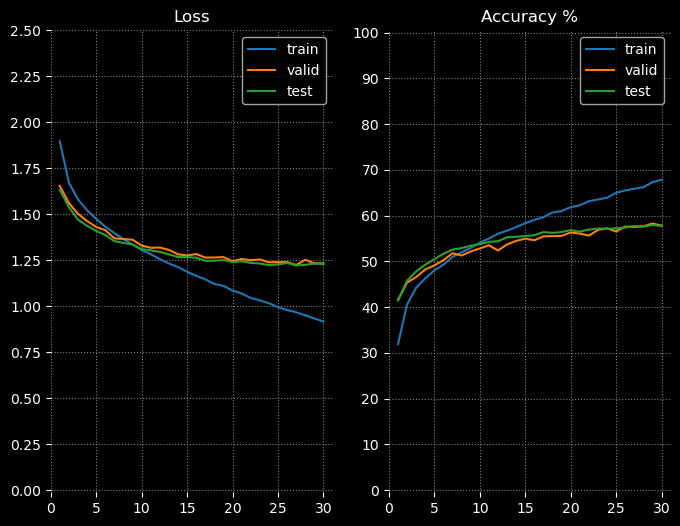

In [23]:
rseed = 6174
torch.manual_seed(rseed)

train_set.transform = basic_transform

modelMLP = SimpleMLP()
modelMLP.set_dropout(0.5)
modelMLP = modelMLP.to(device)

learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_basic_drop = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

Notiamo che il dropout ritarda l'insorgere precoce dell'overfitting consentendo su 30 epoche delle accuracy non troppo diverse da quelle ottenute negli esperimenti 2.A2 e 2.C (l'estensione di 2.A2 a 30 epoche): 57.7% di accuracy sul test set contro 59.9% in 1.A2.

Notiamo che le loss ottenute con dropout hanno dei valori un po' più grandi rispetto a quelle in 2.C: poiché il dropout è una tecnica di regolarizzazione che spegne casualmente alcuni neuroni durante l'addestramento, nell'ottica di prevenire l'overfitting, tale aletorietà rende l'apprendimento più difficile da parte della rete.

#### Esperimento 2.E2 (dropout con data augmentation)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 31.1%		 1.911		 40.9%		 1.669		 | 41.2%	 1.645
2 	 0.00010	 39.2%		 1.704		 44.5%		 1.583		 | 45.2%	 1.550
3 	 0.00010	 42.3%		 1.626		 46.0%		 1.528		 | 47.4%	 1.495
4 	 0.00010	 44.4%		 1.576		 48.6%		 1.475		 | 49.3%	 1.445
5 	 0.00010	 45.7%		 1.538		 48.6%		 1.445		 | 51.0%	 1.404
6 	 0.00010	 46.7%		 1.510		 49.1%		 1.428		 | 51.4%	 1.391
7 	 0.00010	 47.5%		 1.484		 50.5%		 1.401		 | 52.0%	 1.373
8 	 0.00010	 48.5%		 1.462		 50.8%		 1.385		 | 53.4%	 1.354
9 	 0.00010	 49.2%		 1.442		 50.7%		 1.361		 | 53.1%	 1.339
10 	 0.00010	 49.8%		 1.431		 50.5%		 1.363		 | 53.5%	 1.330
11 	 0.00010	 50.4%		 1.410		 52.4%		 1.339		 | 54.6%	 1.315
12 	 0.00010	 50.9%		 1.394		 52.3%		 1.325		 | 54.7%	 1.301
13 	 0.00010	 51.3%		 1.385		 52.3%		 1.309		 | 55.1%	 1.288
14 	 0.000

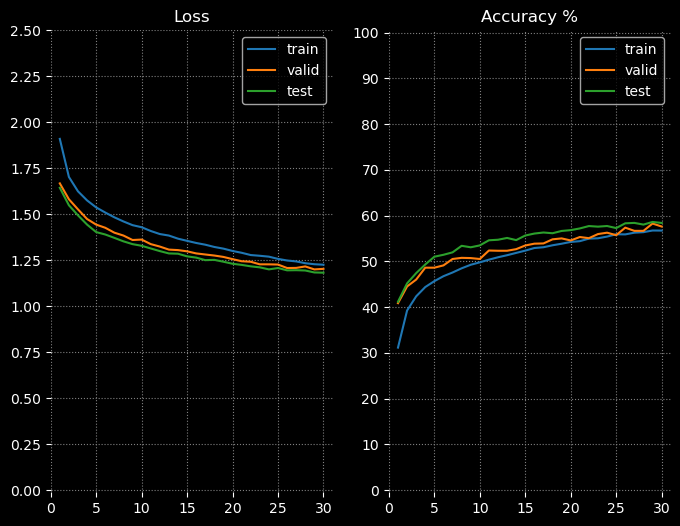

In [24]:
rseed = 6174
torch.manual_seed(rseed)

train_set.transform = augmented_transform

modelMLP = SimpleMLP()
modelMLP.set_dropout(0.5)
modelMLP = modelMLP.to(device)

learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP_aug_drop = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

### Riepilogo sul dropout

In entrambi i casi si assiste ad un andamento più regolare della loss sia su `valid_set` che `test_set`; in particolare, applicando anche la data augmentation, le due loss di `valid_set` e `test_set` restano vicine alla loss sul training set (segno che non siamo ancora arrivati all'overfitting). 

Tuttavia la convergenza verso il minimo è più lenta, per cui per poter osservare un effettivo beneficio del dropout combinato alla data augmentation, occorrebbe addestrare la rete per più epoche: su 30 epoche l'impiego combinato di data augmentation e dropout nell'esperimento 2.E2 consente un'accuracy sul test set pari al 58.6%, ma stavolta siamo ancora nelle fasi preliminari dell'addestramento.

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

## SimpleCNN
La classe `SimpleCNN` definisce tre strati convoluzionali per l'estrazione delle featues e tre strati fully connected per la classificazione. Come per `SimpleMLP`, La classe prevede anche l'impiego di dropout (qui inserito a valle del secondo strato convoluzionale, ossia sempre nella parte fully connected); anche in questo caso è possibile attivarlo attraverso il metodo della classe `set_droput(dropout_perc)`.

In [25]:
# Your code here.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Strati convoluzionali
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=96, kernel_size=3, padding=1, padding_mode ='zeros')
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=384, kernel_size=3, padding=1, padding_mode ='zeros')
        self.conv3 = nn.Conv2d(in_channels=384, out_channels=64, kernel_size=3, padding=1, padding_mode ='zeros')

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 
        self.flatten = torch.nn.Flatten()
        # strati Fully connected
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # 64 canali 4x4 dopo il max-pooling
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)  
        # dropout
        self.dropout_perc = 0
        self.dropout = nn.Dropout(self.dropout_perc)


    def set_dropout(self, dropout_perc):
        self.dropout_perc = dropout_perc
        self.dropout = nn.Dropout(dropout_perc)
    
    def do_dropout(self, x):
        if self.dropout_perc > 0:
            return self.dropout(x)
        else: 
            return(x)
    

    def forward(self, x):
        # estrazione delle features
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #
        # conversione in vettore 1D
        x = self.flatten(x)
        #
        # classificazione
        x = self.do_dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.do_dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        # output
        x = self.fc3(x)
        return x


La funzione `predict_single_image()` accetta in ingresso una singola immagine `X` a cui applica la predizione di `model`.
Con `check_image_prediction()` è possibile verificare se la predizione ottenuta da `predict_single_image()` è corretta o meno, a confronto con l'etichetta di ground truth. 

In [26]:
def predict_single_image(model, X, categories):
    with torch.no_grad():
        model.eval()
        X_batch = X.unsqueeze(0)  # Risultato: 1x3x32x32, per essere conforme a come lavora flatten
        pred_logit = model(X_batch)
        y_softmax = nn.functional.softmax(pred_logit, dim=1)
        y_pred = torch.argmax(y_softmax)
        cat_pred = categories[y_pred]

    return cat_pred    

def check_image_prediction(model, X, y, categories):
    cat_pred = predict_single_image(model, X, categories)
    
    X_den = Cifar10Subset.denormalize_image(X)

    fig, ax = plt.subplots(figsize=(2, 2))
    
    plt.imshow(X_den.permute(1, 2, 0))
    plt.title('Ground Truth: ' + categories[y])
    ax.set_xlabel('Pred: ' + cat_pred)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])    
    
    plt.show()

### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before. Critically compare its performance with the MLP baseline above.

#### Esperimento 3.A (cfr. 2.C)

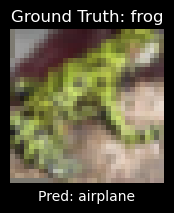

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 30.1%		 1.934		 39.2%		 1.678		 | 39.6%	 1.650
2 	 0.00010	 42.0%		 1.593		 46.2%		 1.493		 | 46.1%	 1.477
3 	 0.00010	 46.2%		 1.481		 48.0%		 1.426		 | 47.8%	 1.418
4 	 0.00010	 48.9%		 1.414		 51.1%		 1.364		 | 51.4%	 1.352
5 	 0.00010	 51.2%		 1.358		 53.2%		 1.315		 | 53.8%	 1.297
6 	 0.00010	 53.0%		 1.314		 54.9%		 1.261		 | 54.3%	 1.247
7 	 0.00010	 54.5%		 1.278		 54.1%		 1.271		 | 54.6%	 1.259
8 	 0.00010	 55.7%		 1.243		 56.4%		 1.237		 | 55.7%	 1.220
9 	 0.00010	 57.0%		 1.209		 58.5%		 1.168		 | 58.4%	 1.158
10 	 0.00010	 58.1%		 1.177		 59.6%		 1.197		 | 57.9%	 1.184
11 	 0.00010	 59.4%		 1.149		 60.4%		 1.126		 | 60.0%	 1.114
12 	 0.00010	 60.1%		 1.128		 63.0%		 1.084		 | 61.6%	 1.077
13 	 0.00010	 61.4%		 1.096		 60.9%		 1.128		 | 60.7%	 1.110
14 	 0.000

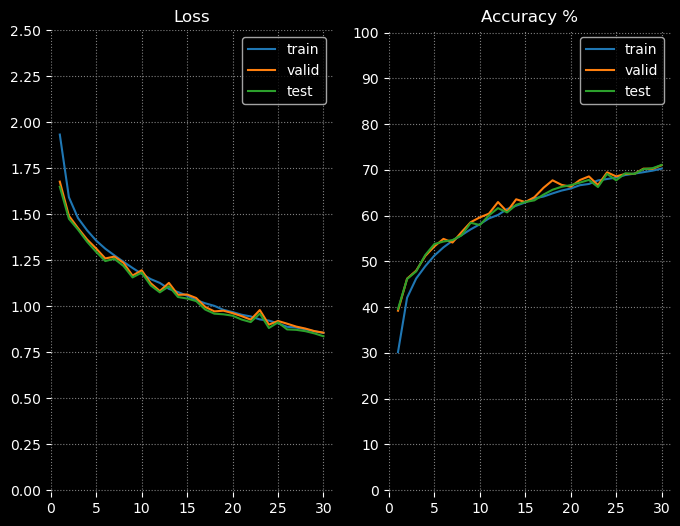

In [27]:
# Your code here.
rseed = 6174
torch.manual_seed(rseed)
train_set.transform = augmented_transform

modelCNN = SimpleCNN()

X_try, y_try = train_set[123]
check_image_prediction(modelCNN, X_try, y_try, train_set.classes)


modelCNN = modelCNN.to(device)
learning_rate =1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestCNN_aug = trainModel(epochs, modelCNN, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)


L'addestramento produce il modello con loss minima su `valid_test` all'epoca #30 a cui corrisponde un'accuratezza su **`test_set` pari a 71.0%**: un netto miglioramento rispetto alla rete MLP addestrata nelle stesse condizioni di lavoro (59.9% su `test_set` nell'esperimento 2.C). 

Il fatto che le curve di loss per `valid_test` e `test_test` restino per tutte le 30 epoche attaccate alla loss del training set fa pensare che il learning rate di $10^{-4}$ sia un po' basso dal momento che siamo probabilmente ancora nella fase preliminare dell'addestramento durante la quale c'è totale accordo tra le metriche valutate sui tre insiemi.

Controlliamo se adesso l'addestramento consenta di classificare correttamente l'esempio in X_try (la rete non allenata aveva risposto airplane).

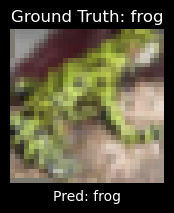

In [28]:
bestCNN_aug.to('cpu')
check_image_prediction(bestCNN_aug, X_try, y_try, train_set.classes)

Predizione stavolta corretta!

### Senza data augmentation

Ripetiamo anche in questo caso un esperimento analogo a quello in 2.D, rimuovendo la deformazione casuale delle immagini nei batch del training set.

#### Esperimento 3.B (cfr. 2.D, senza data augmentation)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 30.6%		 1.926		 39.9%		 1.676		 | 40.1%	 1.650
2 	 0.00010	 43.5%		 1.561		 45.6%		 1.503		 | 45.5%	 1.480
3 	 0.00010	 47.7%		 1.444		 49.5%		 1.420		 | 49.2%	 1.396
4 	 0.00010	 50.5%		 1.371		 53.9%		 1.344		 | 52.0%	 1.327
5 	 0.00010	 53.1%		 1.310		 53.8%		 1.302		 | 53.8%	 1.290
6 	 0.00010	 55.1%		 1.257		 57.2%		 1.254		 | 55.4%	 1.242
7 	 0.00010	 56.6%		 1.218		 55.6%		 1.248		 | 56.1%	 1.238
8 	 0.00010	 58.3%		 1.172		 59.1%		 1.179		 | 57.9%	 1.165
9 	 0.00010	 59.7%		 1.136		 60.9%		 1.146		 | 59.1%	 1.138
10 	 0.00010	 61.4%		 1.100		 60.9%		 1.115		 | 60.8%	 1.107
11 	 0.00010	 62.3%		 1.068		 63.6%		 1.076		 | 61.9%	 1.074
12 	 0.00010	 63.4%		 1.042		 63.9%		 1.066		 | 62.7%	 1.063
13 	 0.00010	 64.3%		 1.016		 64.4%		 1.024		 | 63.8%	 1.020
14 	 0.000

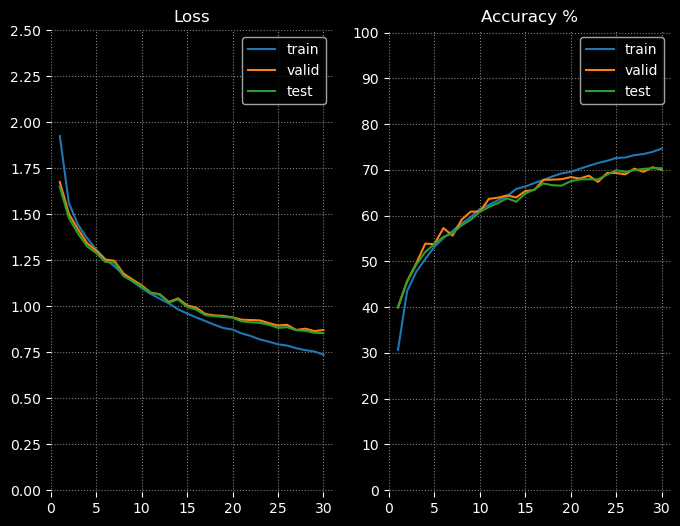

In [29]:
rseed = 6174
torch.manual_seed(rseed)
train_set.transform = basic_transform

modelCNN = SimpleCNN()
modelCNN = modelCNN.to(device)
learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestCNN_basic = trainModel(epochs, modelCNN, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)


Stavolta la data augmentation è molto meno incisiva nell'ottenere un buon addestramento: a differenza della rete MLP (cfr l'esperimento 2.D), le curve di loss che otteniamo per il set di validazione e di test restano vicine a quella di training. 

Il motivo di tale differenza risiede nella diversa architettura delle due reti.
* Nella rete MLP i pesi sono vincolati in modo _assoluto_ alla disposizione dei pixel, una volta che l'immagine è stata rimodellata come vettore 1D; per cui sottoporre la rete MLP a variazioni sulla posizione dei soggetti inquadrati consente di non imparare in modo "pedante" il dislocamento dei soggetti nelle varie immagini del training set.
* Nella rete CNN invece gli strati convoluzionali operano in modo _relativo_ sull'immagine, proprio grazie all'operazione di convoluzione che fa muovere i pesi dei kernel su tutta la foto; pertanto le feature che estraggono, e che vengono poi passate agli strati di classificazione, sono molto meno dipendenti da dove si trovano nelle foto i soggetti ritratti.

### Con dropout
#### Esperimento 3.C1 (come 2.E1, dropout senza data augmentation)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 19.8%		 2.142		 33.0%		 1.872		 | 34.2%	 1.852
2 	 0.00010	 31.4%		 1.830		 39.9%		 1.637		 | 40.9%	 1.624
3 	 0.00010	 36.5%		 1.690		 45.8%		 1.513		 | 45.4%	 1.505
4 	 0.00010	 40.4%		 1.600		 47.6%		 1.448		 | 47.9%	 1.441
5 	 0.00010	 42.7%		 1.543		 49.7%		 1.395		 | 49.8%	 1.385
6 	 0.00010	 44.7%		 1.491		 52.0%		 1.345		 | 51.6%	 1.339
7 	 0.00010	 46.4%		 1.452		 54.5%		 1.306		 | 53.1%	 1.304
8 	 0.00010	 47.9%		 1.414		 55.1%		 1.274		 | 54.4%	 1.268
9 	 0.00010	 49.7%		 1.382		 56.6%		 1.225		 | 56.0%	 1.222
10 	 0.00010	 50.8%		 1.348		 57.9%		 1.191		 | 57.2%	 1.189
11 	 0.00010	 51.8%		 1.321		 58.6%		 1.168		 | 58.4%	 1.165
12 	 0.00010	 52.9%		 1.300		 60.0%		 1.135		 | 59.2%	 1.135
13 	 0.00010	 54.0%		 1.271		 60.9%		 1.116		 | 59.8%	 1.116
14 	 0.000

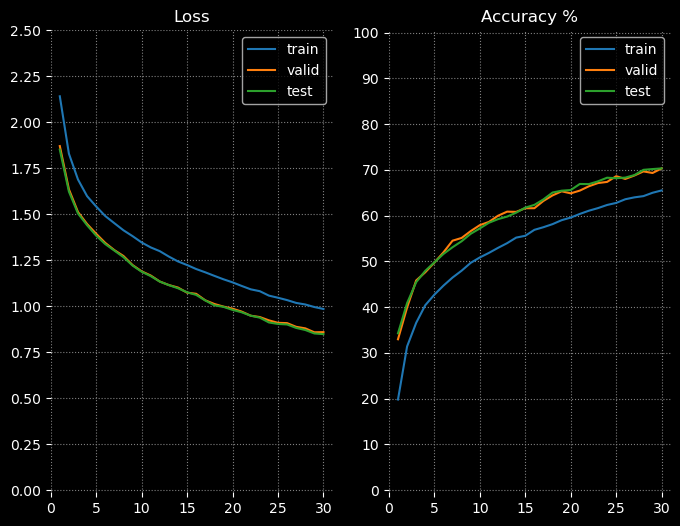

In [30]:
rseed = 6174
torch.manual_seed(rseed)
train_set.transform = basic_transform

modelCNN = SimpleCNN()
modelCNN.set_dropout(0.5)
modelCNN = modelCNN.to(device)
learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestCNN_basic_drop = trainModel(epochs, modelCNN, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)



#### Esperimento 3.C2 (come 2.E2, dropout con data augmentation)
Testiamo il dropout ripristinando anche la data augmentation.

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 19.4%		 2.150		 32.1%		 1.879		 | 33.4%	 1.859
2 	 0.00010	 30.7%		 1.860		 40.2%		 1.638		 | 41.1%	 1.625
3 	 0.00010	 35.7%		 1.721		 44.4%		 1.535		 | 44.5%	 1.524
4 	 0.00010	 38.8%		 1.650		 45.6%		 1.484		 | 46.5%	 1.474
5 	 0.00010	 41.0%		 1.590		 48.2%		 1.438		 | 47.7%	 1.430
6 	 0.00010	 42.7%		 1.549		 48.9%		 1.372		 | 49.8%	 1.360
7 	 0.00010	 44.3%		 1.508		 48.5%		 1.376		 | 49.5%	 1.367
8 	 0.00010	 45.6%		 1.486		 50.6%		 1.331		 | 51.5%	 1.323
9 	 0.00010	 46.5%		 1.449		 51.1%		 1.299		 | 51.9%	 1.288
10 	 0.00010	 47.8%		 1.426		 54.2%		 1.274		 | 53.9%	 1.270
11 	 0.00010	 48.8%		 1.405		 54.0%		 1.266		 | 53.8%	 1.258
12 	 0.00010	 49.7%		 1.380		 55.9%		 1.207		 | 55.9%	 1.204
13 	 0.00010	 50.3%		 1.362		 55.5%		 1.205		 | 56.0%	 1.199
14 	 0.000

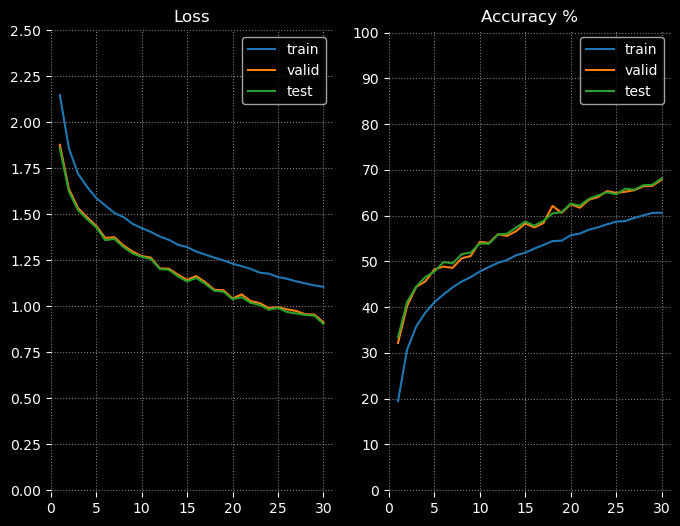

In [31]:
rseed = 6174
torch.manual_seed(rseed)
train_set.transform = augmented_transform

modelCNN = SimpleCNN()
modelCNN.set_dropout(0.5)
modelCNN = modelCNN.to(device)
learning_rate = 1.0e-4
epochs = 30

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestCNN_aug_drop = trainModel(epochs, modelCNN, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)


### Riepilogo sul dropout
Notiamo che i grafici con e senza data augmentation hanno andamenti paragonabili, con le curve per gli insiemi di validazione e di test quasi parallele a quella di training: nel caso 3.C2, cioè in combinazione con la data augmentation, le curve della loss assumono valori maggiori (compresa la loss sul training set) rispetto al caso 3.C1 e per gli insiemi di validazione e di test sia loss che accuracy appaiono un po' "nervose" se paragonate a quelle senza data agumentation.

Il ruolo meno importante della data augmentation per la rete CNN spiega la similarità tra i risultati nei due esperimenti, governati in prevalenza dal dropout; al tempo stesso il nervosismo esibito su validation e test set durante l'addestramento può essere ricondotto all'aleatorietà introdotta proprio dalla data augmentation, così come i valori maggiori delle loss rispetto al caso 3.C1.

## Modelli a confronto
Confrontiamo le prestazioni ottenute con la rete MLP e con la rete CNN nei vari esperimenti:
* 2.C (MLP) / 3.A (CNN), ossia l'addestramento di base impiegando la data agumentation;
* 2.D (MLP) / 3.B (CNN), senza data augmentation
* 2.E1 (MLP) / 3.C1 (CNN), per il dropout senza data augmentation
* 2.E2 (MLP) / 3.C2 (CNN), per il dropout con data augmentation

Ricordiamo che l'addestramento di base prevede:
* learning rate costante e pari a $10^{-4}$, con Adam come ottimizzatore
* nessun label smoothing
* addestramento su 30 epoche

| Esperimento             | MLP Train loss | MLP Val. loss | MLP Val. Acc. | MLP Test Acc. | | CNN Train loss | CNN Val. loss | CNN Val. Acc. | CNN Test Acc. |
--------------------------|----------------|---------------|---------------|---------------|-|----------------|---------------|---------------|---------------|
| 2.C (MLP) / 3.A (CNN)   |          0.941 |         1.167 |         60.5% |         59.9% | |          0.856 |         0.857 |         71.0% |         71.1% |
| 2.D (MLP) / 3.B (CNN)   |          1.124 |         1.325 |         53.0% |         54.1% | |          0.755 |         0.866 |         70.5% |         70.3% |
| 2.E1 (MLP) / 3.C1 (CNN) |          0.968 |         1.225 |         57.5% |         57.7% | |          0.997 |         0.859 |         69.3% |         70.2% |
| 2.E2 (MLP) / 3.C2 (CNN) |          1.229 |         1.201 |         58.2% |         58.6% | |          1.107 |         0.914 |         67.8% |         68.1% |

La superiorità della rete CNN è netta: incide molto il fatto che l'architettura di una rete MLP non sia robusta a dislocazioni arbitrarie del soggetto inquadrato nelle immagini, e meno adatta a costruire delle rappresentazioni interne riccamente informative delle immagini in input.. 

L'addestramento condotto mostra segnali di overfitting per la rete MLP già nelle prime 30 epoche, mentre la rete convoluzionale sembra avere ancora spazio per migliorare la predizione su `valid_set`: anche questo è riconducibile alla minor capacità di generalizzare per la rete MLP.

# Addestramenti "in libertà"
In questa sezione _extra_ si vuole cercare di migliorare le prestazioni delle due reti, MLP e CNN, cercando di raggiungere il limite delle capacità predittive di entrambi i modelli portando le epoche di addestramento a 60, e diversificando ad hoc le condizioni di lavoro.

## Modello MLP
Avevamo visto che la rete MLP con l'ausilio del dropout combinato alla data augmentation mostrava una maggiore stabilità, contrapposta però ad una convergenza più lenta. 

Si vuole quindi osservare il comportamento della rete su 60 epoche invece che 30, facendo ricorso anche al label smoothing per guadagnare qualche decimale nell'accuratezza sul test set dato che in sua assenza l'accuracy risulta 61.3% mentre impiegandolo si arriva a 61.6% (ma sembra un incremento quasi aleatorio, senza un pattern evidente).

I valori trovati sono ancora suscettibili di qualche miglioramento estendendo ulteriormente il numero di epoche dato che in 60 epoche non si è ancora arrivati all'overfitting.

### Esperimento 4.A1 (come 2C, ma su 60 epoche)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 31.1%		 1.911		 40.9%		 1.669		 | 41.2%	 1.645
2 	 0.00010	 39.2%		 1.704		 44.5%		 1.583		 | 45.2%	 1.550
3 	 0.00010	 42.3%		 1.626		 46.0%		 1.528		 | 47.4%	 1.495
4 	 0.00010	 44.4%		 1.576		 48.6%		 1.475		 | 49.3%	 1.445
5 	 0.00010	 45.7%		 1.538		 48.6%		 1.445		 | 51.0%	 1.404
6 	 0.00010	 46.7%		 1.510		 49.1%		 1.428		 | 51.4%	 1.391
7 	 0.00010	 47.5%		 1.484		 50.5%		 1.401		 | 52.0%	 1.373
8 	 0.00010	 48.5%		 1.462		 50.8%		 1.385		 | 53.4%	 1.354
9 	 0.00010	 49.2%		 1.442		 50.7%		 1.361		 | 53.1%	 1.339
10 	 0.00010	 49.8%		 1.431		 50.5%		 1.363		 | 53.5%	 1.330
11 	 0.00010	 50.4%		 1.410		 52.4%		 1.339		 | 54.6%	 1.315
12 	 0.00010	 50.9%		 1.394		 52.3%		 1.325		 | 54.7%	 1.301
13 	 0.00010	 51.3%		 1.385		 52.3%		 1.309		 | 55.1%	 1.288
14 	 0.000

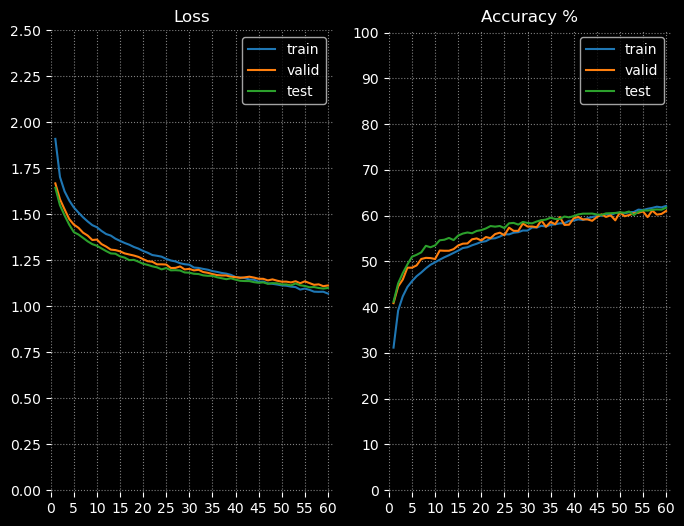

In [32]:
rseed = 6174
torch.manual_seed(rseed)

train_set.transform = augmented_transform

modelMLP = SimpleMLP()
modelMLP.set_dropout(0.5)
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-4
epochs = 60

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

### Esperimento 4.A2 (come 4.A1, ma con label smoothing)

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00010	 31.4%		 2.059		 41.5%		 1.909		 | 41.8%	 1.896
2 	 0.00010	 39.5%		 1.938		 44.6%		 1.859		 | 45.4%	 1.840
3 	 0.00010	 42.6%		 1.894		 46.2%		 1.829		 | 47.7%	 1.811
4 	 0.00010	 44.4%		 1.867		 48.0%		 1.798		 | 49.5%	 1.781
5 	 0.00010	 45.9%		 1.844		 49.2%		 1.779		 | 50.9%	 1.758
6 	 0.00010	 46.7%		 1.828		 49.2%		 1.770		 | 51.4%	 1.750
7 	 0.00010	 47.6%		 1.813		 49.4%		 1.758		 | 52.0%	 1.741
8 	 0.00010	 48.5%		 1.800		 50.5%		 1.748		 | 53.0%	 1.730
9 	 0.00010	 49.2%		 1.789		 50.4%		 1.734		 | 53.2%	 1.720
10 	 0.00010	 49.7%		 1.781		 51.0%		 1.736		 | 53.5%	 1.714
11 	 0.00010	 50.4%		 1.770		 52.0%		 1.722		 | 54.4%	 1.706
12 	 0.00010	 51.2%		 1.759		 51.6%		 1.710		 | 54.2%	 1.697
13 	 0.00010	 51.6%		 1.753		 52.4%		 1.702		 | 54.9%	 1.689
14 	 0.000

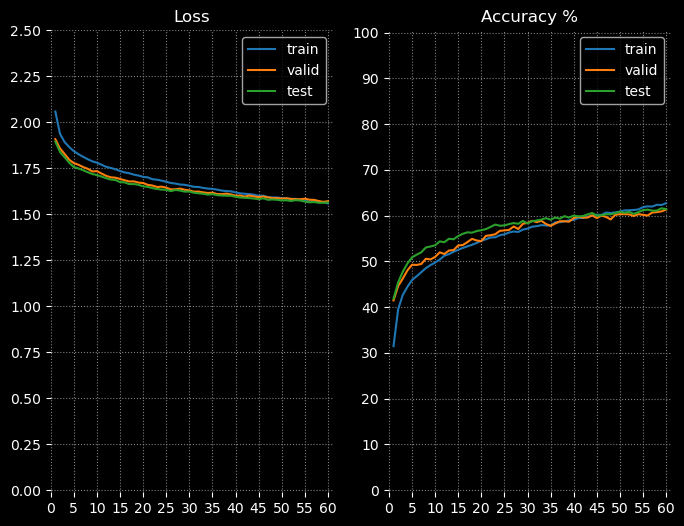

In [33]:
rseed = 6174
torch.manual_seed(rseed)

train_set.transform = augmented_transform

modelMLP = SimpleMLP()
modelMLP.set_dropout(0.5)
modelMLP = modelMLP.to(device)
learning_rate = 1.0e-4
epochs = 60

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestMLP = trainModel(epochs, modelMLP, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)

## Modello CNN

I risultati ottenuti con la rete CNN sono stati ottenuti in condizioni non ottimali per il modello convoluzionale, bensì favorevoli semmai alla rete MLP sulla quale era stato tarato il learning rate: l'impressione è che $10^{-4}$ sia un learning rate un po' basso per la CNN.

Pertanto il seguente addestramento è condotto con learning rate pari a $10^{-3}$, sempre su 60 epoche, facendo ricorso al dropout con data augmentation per vedere anche in questo caso cosa accade. Il label smoothing invece sembra non portare benefici (da prove a latere, qui non riportate per brevità).

### Esperimento 4.B

Epoch	 learn. rate	 Train Acc.	 Train Loss	 Val. Acc.	 Val. Loss	 | Test Acc.	 Test Loss
--------------------------------------------------------------------------------------------------------------------
1 	 0.00100	 40.1%		 1.637		 48.5%		 1.408		 | 49.2%	 1.384
2 	 0.00100	 54.7%		 1.255		 60.2%		 1.127		 | 59.5%	 1.113
3 	 0.00100	 61.7%		 1.069		 64.7%		 1.006		 | 64.8%	 0.993
4 	 0.00100	 66.5%		 0.950		 67.5%		 0.985		 | 66.5%	 0.968
5 	 0.00100	 69.3%		 0.878		 71.5%		 0.836		 | 71.3%	 0.829
6 	 0.00100	 71.1%		 0.819		 71.5%		 0.814		 | 72.5%	 0.787
7 	 0.00100	 72.8%		 0.774		 72.7%		 0.787		 | 72.8%	 0.785
8 	 0.00100	 74.0%		 0.744		 74.9%		 0.738		 | 74.9%	 0.726
9 	 0.00100	 75.2%		 0.713		 75.5%		 0.711		 | 75.9%	 0.699
10 	 0.00100	 76.2%		 0.680		 75.7%		 0.704		 | 76.1%	 0.680
11 	 0.00100	 77.2%		 0.652		 75.8%		 0.722		 | 76.0%	 0.704
12 	 0.00100	 78.2%		 0.626		 76.5%		 0.701		 | 76.4%	 0.684
13 	 0.00100	 78.8%		 0.609		 77.3%		 0.681		 | 77.0%	 0.674
14 	 0.001

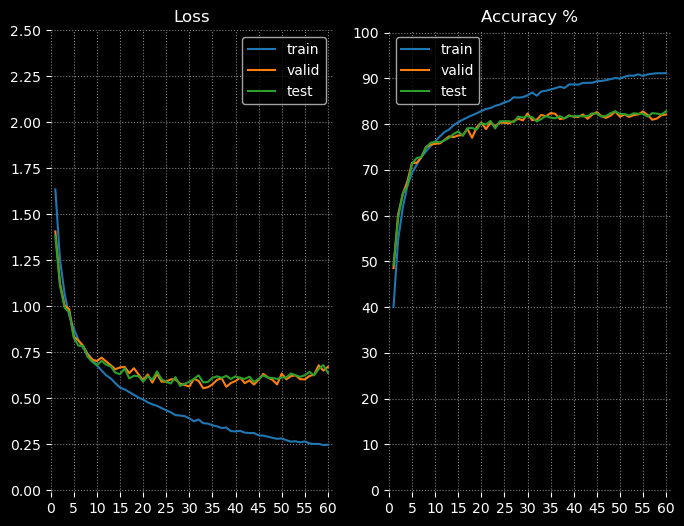

In [34]:
# Your code here.
rseed = 6174
torch.manual_seed(rseed)
train_set.transform = augmented_transform

modelCNN = SimpleCNN()
modelMLP.set_dropout(0.5)
modelCNN = modelCNN.to(device)
learning_rate = 1.0e-3
epochs = 60

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.0) # da prove effettuate a parte, label smoothing non migliora l'accuracy
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=1) 
bestCNN = trainModel(epochs, modelCNN, loss_fn, optimizer, scheduler, train_loader, valid_loader, test_loader, rseed, device)


Il learning rate più elevato ha consentito di accelerare il processo di apprendimento, mettendo in evidenza come anche la rete CNN con dropout e data augmentation mostri segni di overfitting poco dopo le 30 epoche, con le loss per il validation set ed il test set che riprendono leggermente ad aumentare: il modello migliore viene individuato all'epoca #33, ma stavolta **l'accuracy sul test set arriva a 81.1%** (mentre la MLP migliora di poco, restando sul 61%).

# _Future_ works
Ci sono probabilmente ulteriori margini di miglioramento: 
* provando a cambiare i pesi iniziali per le due tipologie di reti;
* prendendo in considerazione delle modifiche alle due architetture;
* validando alcuni dei parametri fissati "a priori" come la percentuale per il dropout (posta a 0.5 d'ufficio), oppure variando i parametri di Adam lasciati con i valori di default (i coefficienti per i due momenti);
* estendendo ulteriormente il numero di epoche e variando il learning rate andando avanti nell'addestramento (sebbene presente, lo scheduler di fatto non è mai stato impiegato in alcuno degli esperimenti nel notebook)
